# A/B testing project


## Background

The task is to evaluate the results of the A/B-Test. We have a datasets with user actions, a technical task and several auxiliary datasets at our disposal.

- Evaluate the correctness of the test
- Analyze test results

## Technical task

- Test name: `recommender_system_test`;
- groups: A - control, B - new payment funnel;
- launch date: 2020-12-07;
- date of stopping the recruitment of new users: 2020-12-21;
- stop date: 2021-01-04;
- audience: 15% of new users from the EU region;
- purpose of the test: testing changes related to the introduction of an improved recommender system;
- expected number of test participants: 6000.
- expected effect: in 14 days from the moment of registration, users will show an improvement in each metric by at least 10%:
     - `product_page`,
     - `product_cart`,
     - `purchase`.

## Data Description

`ab_project_marketing_events.csv` - calendar of marketing events for 2020.

File structure:

- `name` — marketing event name;
- `regions` - regions in which the advertising campaign will be carried out;
- `start_dt` — campaign start date;
- `finish_dt` — end date of the campaign.

`final_ab_new_users.csv` - users who registered from 7 to 21 December 2020.

File structure:

- `user_id` - user ID;
- `first_date` — registration date;
- `region` — user's region;
- `device` — the device from which registration took place.

`final_ab_events.csv` - actions for new users from December 7, 2020 to January 4, 2021.

File structure:

- `user_id` - user ID;
- `event_dt` - date and time of purchase;
- `event_name` — event type;
- `details` - additional data about the event. For example, for purchases, `purchase,` this field stores the cost of the purchase in dollars.

`final_ab_participants.csv` - table of test participants.

File structure:

- `user_id` - user ID;
- `ab_test` — test name;
- `group` — user group.

## Let's open and study general information about the data

In [1]:
! gdown -- 1nnwvut4fwpwwQb8uX92Qx_2GlxlDrZdK
! gdown -- 1x6igMvlG7Ev_7K1XbGv31i1W8ceie1bw
! gdown -- 1zHpPW-7NcnazhY3FMBIjO4VqRLuZ2BVJ
! gdown -- 1v5NrEAJLTrDpp43wiB9h90Y48hl38Tdj

Downloading...
From: https://drive.google.com/uc?id=1nnwvut4fwpwwQb8uX92Qx_2GlxlDrZdK
To: /content/final_ab_events.csv
100% 22.3M/22.3M [00:00<00:00, 186MB/s]
Downloading...
From: https://drive.google.com/uc?id=1x6igMvlG7Ev_7K1XbGv31i1W8ceie1bw
To: /content/ab_project_marketing_events.csv
100% 879/879 [00:00<00:00, 1.40MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zHpPW-7NcnazhY3FMBIjO4VqRLuZ2BVJ
To: /content/final_ab_new_users.csv
100% 2.37M/2.37M [00:00<00:00, 126MB/s]
Downloading...
From: https://drive.google.com/uc?id=1v5NrEAJLTrDpp43wiB9h90Y48hl38Tdj
To: /content/final_ab_participants.csv
100% 716k/716k [00:00<00:00, 88.2MB/s]


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go
import numpy as np
import pylab 
import math as mth
from datetime import datetime, timedelta

from scipy import stats as st
import statsmodels.sandbox.stats.multicomp as multi_correction

pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_colwidth', None)

In [3]:
def open(df_google_csv, df_ya_csv):
    try:
        df = pd.read_csv(df_google_csv)
    except:
        df = pd.read_csv(df_ya_csv)
    display(df.info(), df.head(3))
    return df  
    

In [4]:
events = open('/content/final_ab_events.csv', 'https://code.s3.yandex.net/datasets/final_ab_events.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99


In [5]:
users = open('/content/final_ab_new_users.csv', 'https://code.s3.yandex.net/datasets/final_ab_new_users.csv') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC


In [6]:
participants = open('/content/final_ab_participants.csv', 'https://code.s3.yandex.net/datasets/final_ab_participants.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test


In [7]:
marketing = open('/content/ab_project_marketing_events.csv', 'https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19


The data opened without comment. In some columns we need to change the types.

## Data preprocessing

In [8]:
users.isna().mean()

user_id      0.00
first_date   0.00
region       0.00
device       0.00
dtype: float64

In [9]:
users.duplicated().sum()

0

In [10]:
events.isna().mean()

user_id      0.00
event_dt     0.00
event_name   0.00
details      0.86
dtype: float64

In [11]:
events.duplicated().sum()

0

In [12]:
participants.isna().mean()

user_id   0.00
group     0.00
ab_test   0.00
dtype: float64

In [13]:
participants.duplicated().sum()

0

In [14]:
marketing.isna().mean()

name        0.00
regions     0.00
start_dt    0.00
finish_dt   0.00
dtype: float64

In [15]:
marketing.duplicated().sum()

0

In [16]:
users['first_date'] = pd.to_datetime(users['first_date'], format=('%Y-%m-%d'))

events['event_dt_date'] = pd.to_datetime(events['event_dt']).dt.date
events['event_dt_date'] = pd.to_datetime(events['event_dt_date'], format=('%Y-%m-%d'))

marketing['start_dt'] =  pd.to_datetime(marketing['start_dt'], format=('%Y-%m-%d'))
marketing['finish_dt'] =  pd.to_datetime(marketing['finish_dt'], format=('%Y-%m-%d'))

We checked dataframes for gaps, obvious duplicates, changed the type in dates. Lots of omissions in event details. Its will not affect further research.

## Evaluate the correctness of the test

### Check the correctness of all points of the Technical task

In [17]:
print('Participants. There are', len(participants), 'rows in the Dataset')

Participants. There are 18268 rows in the dataset


In [18]:
print('There are', participants['user_id'].nunique(), 'unique users in these rows')

There are 16666 unique users in these rows


In [19]:
all_group = set(participants.query('ab_test == "recommender_system_test"')['user_id']) & set(participants.query('ab_test == "interface_eu_test"')['user_id']) 

f'Same users for recommender_system_test and interface_eu_test tests: {len(all_group)}'

'Same users for recommender_system_test and interface_eu_test tests: 1602'

In [20]:
participants = participants.drop_duplicates('user_id')

Removed same users.

In [21]:
all_group = set(participants.query('ab_test == "recommender_system_test"')['user_id']) & set(participants.query('ab_test == "interface_eu_test"')['user_id']) 

f'Same users for recommender_system_test and interface_eu_test tests: {len(all_group)}'

'Same users for recommender_system_test and interface_eu_test tests: 0'

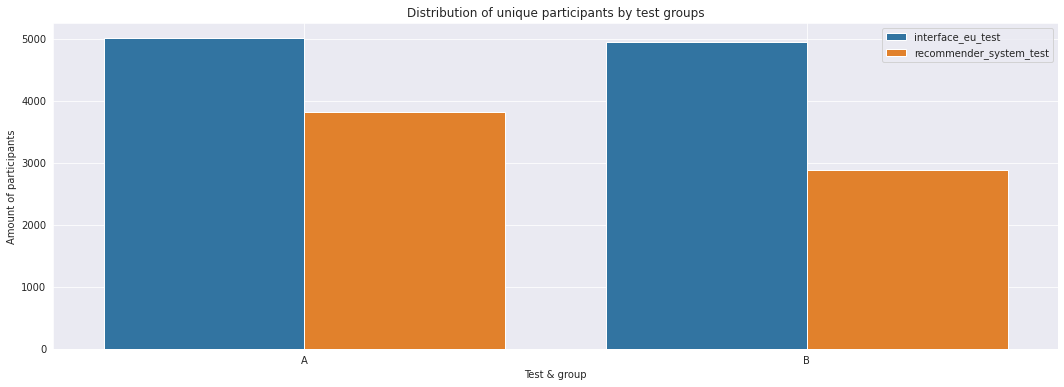

In [22]:
sns.set_style('dark')

plt.figure(figsize=(18, 6))

sns.barplot(x='group', y='user_id', data=participants.groupby(['ab_test', 'group'])['user_id'].nunique().reset_index(), hue='ab_test')

plt.title('Distribution of unique participants by test groups')
plt.xlabel('Test & group')
plt.ylabel('Amount of participants')
plt.legend(loc='upper right', fontsize=10)
plt.grid()

plt.show()

Sequential split test groups equally. The control group of `recommender_system_test` has slightly more users than the test group.

Let's keep the users of the adjacent test to avoid mixing them with the users of our test in the rest of the dataframes.

In [23]:
users_the_othert_test = participants[participants['ab_test'] != 'recommender_system_test']['user_id'].tolist()

In [24]:
participants.groupby(['ab_test', 'group'])['user_id'].count()

ab_test                  group
interface_eu_test        A        5012
                         B        4953
recommender_system_test  A        3824
                         B        2877
Name: user_id, dtype: int64

Participants of two tests are in dataframe. Let's remove the second one to ensure that we get rid of intersections in tests.

In [25]:
participants= participants[participants['ab_test'] == 'recommender_system_test'].copy()

In [26]:
participants.groupby(['ab_test', 'group'])['user_id'].count()

ab_test                  group
recommender_system_test  A        3824
                         B        2877
Name: user_id, dtype: int64

The samples are unevenly distributed. The control group has 1,000 more participants than the testing.

Once again, make sure that there are no user intersections.

In [27]:
all_group = set(participants.query('group == "A"')['user_id']) & set(participants.query('group == "B"')['user_id']) 

f'Same users for groups A and B: {len(all_group)}'

'Identical users for groups A and B: 0'

In [28]:
print('There are', participants['user_id'].nunique(), 'unique users in "recommender_system_test"')

There are 6701 unique users in "recommender_system_test"


Let's study a dataframe with users from all over the world.

In [29]:
total_users = users.copy()

total_users_by_regions = total_users['region'].value_counts()
total_users_by_regions

EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64

Let's leave only European users, because the region of the test is EU.

In [30]:
users = users[users['region'] == 'EU'].copy()

Let's look the dates of registration of European users. First, let's get rid of users from the adjacent test, if any.

In [31]:
before = users['user_id'].nunique()

In [32]:
users = users.query('user_id not in @users_the_othert_test').copy()

In [33]:
after = users['user_id'].nunique()

In [34]:
if before == after:
  print('The amount of unique users has not changed -', after)
else:
  print('The amount of unique users has changed. It was -', before, 'It became -', after,\
        'Changes -', round(((after / before * 100) - 100), 2), '%')

The amount of unique users has changed. It was - 46270 It became - 36305 Changes - -21.54 %


In [35]:
users['first_date'].value_counts().reset_index().sort_values(by = 'index')

,index,first_date
2,2020-12-07,3337
8,2020-12-08,1900
14,2020-12-09,1258
9,2020-12-10,1888
13,2020-12-11,1415
5,2020-12-12,2290
3,2020-12-13,2773
1,2020-12-14,3356
10,2020-12-15,1797
15,2020-12-16,1258


According to the Technical task, users who registered no later than 2020-12-21 participate in the test. Let's cut off the excess.

In [36]:
users = users[users['first_date'] <= '2020-12-21']

In [37]:
users['first_date'].value_counts().reset_index().sort_values(by = 'index')

,index,first_date
2,2020-12-07,3337
8,2020-12-08,1900
13,2020-12-09,1258
9,2020-12-10,1888
12,2020-12-11,1415
5,2020-12-12,2290
3,2020-12-13,2773
1,2020-12-14,3356
10,2020-12-15,1797
14,2020-12-16,1258


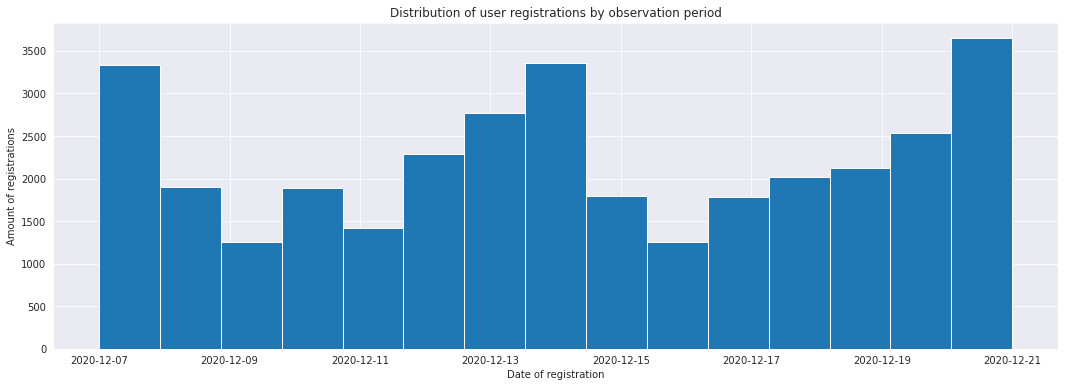

In [38]:
users['first_date'].hist(bins = 15, figsize=(18, 6))

plt.title('Distribution of user registrations by observation period')
plt.xlabel('Date of registration')
plt.ylabel('Amount of registrations');

New users came every day. Peak observation values at the beginning of each test week. These dates are 7, 14, 21 December - Mondays.

In [39]:
print('There are', users['user_id'].nunique(), 'unique users from EU now')

There are 33377 unique users from EU now


Let's remember how many unique test participants we have.

In [40]:
participants['user_id'].nunique()

6701

Let's filter out users, leave those who are test participants.

In [41]:
test_participants = participants['user_id'].tolist()

In [42]:
users = users.query('user_id in @test_participants')

In [43]:
print('Unique users in the begining - ', participants['user_id'].nunique())
print('Unique users after filtering by registration date and region - ', users['user_id'].nunique())
print('Changes - ', round(100 - (users['user_id'].nunique() / participants['user_id'].nunique() * 100), 2), '%')

Unique users in the begining -  6701
Unique users after filtering by registration date and region -  6351
Changes -  5.22 %


Update the `test_participants` variable with unique test participants filtered by region, registration date.

In [44]:
test_participants = users['user_id'].tolist()

Next dataframe.

In [45]:
events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

There is a simple product funnel. The sequence of actions of clients to achieve the goal of the action is not strict. The number of people who paid is greater than the number of those who appear in the cart. Perhaps there are quick purchases on the site or purchases on external sites.

It is logical to assume that the sequence of actions is violated.
Correct sequence:

    login           
    product_page  
    product_cart
    purchase        

We will notice this later.
     

In [46]:
events['event_dt_date'].value_counts().reset_index().sort_values(by = 'index')

,index,event_dt_date
20,2020-12-07,11385
17,2020-12-08,12547
19,2020-12-09,12122
14,2020-12-10,14077
16,2020-12-11,13864
12,2020-12-12,17634
9,2020-12-13,20985
3,2020-12-14,26184
6,2020-12-15,23469
10,2020-12-16,20909


The test lasts from 2020-12-07 to 2021-01-04. In practice, events are limited to 2020-12-30 inclusive. Moreover, the data for the last day is incomplete.

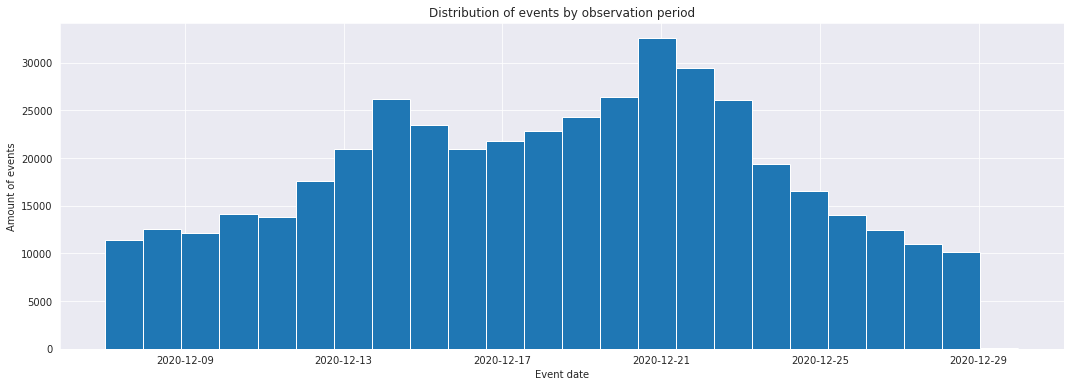

In [47]:
events['event_dt_date'].hist(bins = 24, figsize=(18, 6))

plt.title('Distribution of events by observation period')
plt.xlabel('Event date')
plt.ylabel('Amount of events');

There are no gaps in the days of events in the dataframe. At the beginning of the 20s, before Catholic Christmas, the peak value.

Let's see if there were any marketing activities during the test period.

In [48]:
marketing[(marketing['start_dt'] <= '2021-01-04') | (marketing['finish_dt'] >= '2020-12-07')]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Yes, Christmas and New Year advertising campaign including in Europe. It, like holiday sales, can be considered an external factor that can influence test results. Later we will see whether measurements were taken in parallel by groups to reduce the influence of external factors.

Combine dataframes with test participants and events by filtering by test participants.

In [49]:
events_new = pd.merge(events, participants, how='inner', on='user_id') #inner parameter to include users from participants in the final set,
                                                                       #about the actions of which there is information

events_new.head(3)

,user_id,event_dt,event_name,details,event_dt_date,group,ab_test
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,A,recommender_system_test
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,2020-12-09,A,recommender_system_test
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,2020-12-07,A,recommender_system_test


Additionally, we filter events by unique users that meet the requirements of the Technical task.

In [50]:
events_new = events_new.query('user_id in @test_participants')

In [51]:
if users['user_id'].nunique() == events_new['user_id'].nunique():
  print('Unique users are still', events_new['user_id'].nunique(),'- no one got lost')
else:
  print('Someone got lost. It was -', users['user_id'].nunique(), 'Became -',events_new['user_id'].nunique(),\
        'Changes -', round(((events_new['user_id'].nunique() / users['user_id'].nunique() * 100) - 100), 2), '%')

Someone got lost. It was - 6351 Became - 3481 Changes - -45.19 %


Nearly half of the filtered test participants have no event details. Consider them in more detail.

In [52]:
users_without_events = pd.merge(events, participants, how='right', on='user_id') 

users_without_events = users_without_events[users_without_events['event_dt_date'].isna()]

users_without_events = pd.merge(users, users_without_events, how='inner', on='user_id')

users_without_events = users_without_events.groupby(['first_date', 'group'])['user_id'].nunique().reset_index()

users_without_events['first_date'] = users_without_events['first_date'].dt.strftime('%Y-%m-%d')

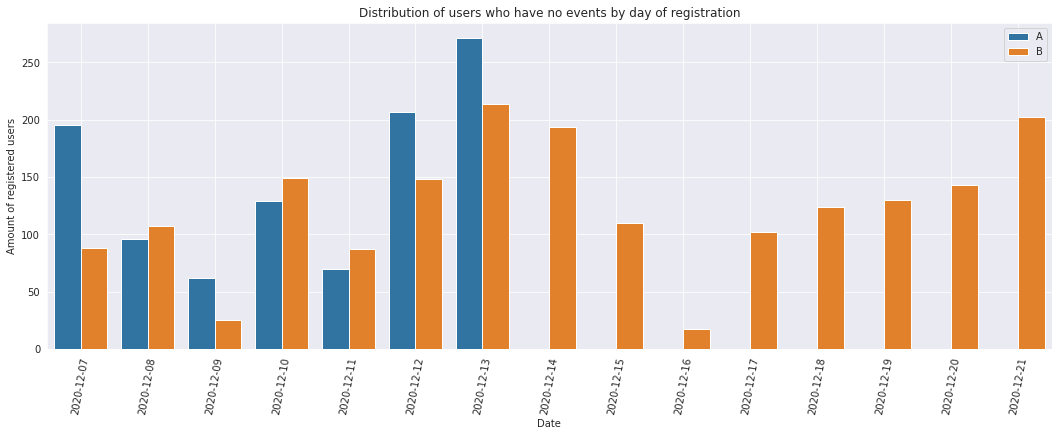

In [53]:
sns.set_style('dark')

plt.figure(figsize=(18, 6))

sns.barplot(x='first_date', y='user_id', data=users_without_events, hue='group')

plt.title('Distribution of users who have no events by day of registration')
plt.xlabel('Date')
plt.ylabel('Amount of registered users')
plt.legend(loc='upper right', fontsize=10)
plt.grid()
plt.xticks(rotation=80)
plt.show()

Found something odd. Starting from Monday, December 14, unique users without events fell only into test group B, while none appeared in A from this period. It's possible that someone made changes to test settings starting December 14th. Or, since this date, an error occurred when users without an event were not included in the control group.

Let's add registration dates to the dataframe with filtered data.

In [54]:
events_new = pd.merge(users, events_new, how='inner', on='user_id') 

events_new.head(3)

,user_id,first_date,region,device,event_dt,event_name,details,event_dt_date,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:10,product_page,NaN,2020-12-07,A,recommender_system_test
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:07,login,NaN,2020-12-07,A,recommender_system_test
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-07 15:32:54,product_page,NaN,2020-12-07,B,recommender_system_test


It is necessary to analyze the 14-day period from the moment of registration of users. Let's consider this requirement.

In [55]:
events_new['14_days_last'] = events_new['first_date']  + timedelta(days=14)

In [56]:
events_new = events_new[events_new['event_dt_date'] <= events_new['14_days_last']].copy()

Let's check the overlapping users in groups again.

In [57]:
all_group = set(events_new.query('group == "A"')['user_id']) & set(events_new.query('group == "B"')['user_id']) 

f'Same users for groups A and B: {len(all_group)}'

'Same users for groups A and B: 0'

In [58]:
print('After filtering at our disposal', events_new['event_dt_date'].count(), 'events, namely:')

After filtering at our disposal 22828 events, namely:


In [59]:
events_new['group'].value_counts()

A    17977
B     4851
Name: group, dtype: int64

In [60]:
events_new['group'].value_counts(normalize=True)

A   0.79
B   0.21
Name: group, dtype: float64

The samples are very different.

In [61]:
events_new.groupby(['group', 'event_name'])['event_dt_date'].count().reset_index()

,group,event_name,event_dt_date
0,A,login,7968
1,A,product_cart,2385
2,A,product_page,5125
3,A,purchase,2499
4,B,login,2345
5,B,product_cart,625
6,B,product_page,1257
7,B,purchase,624


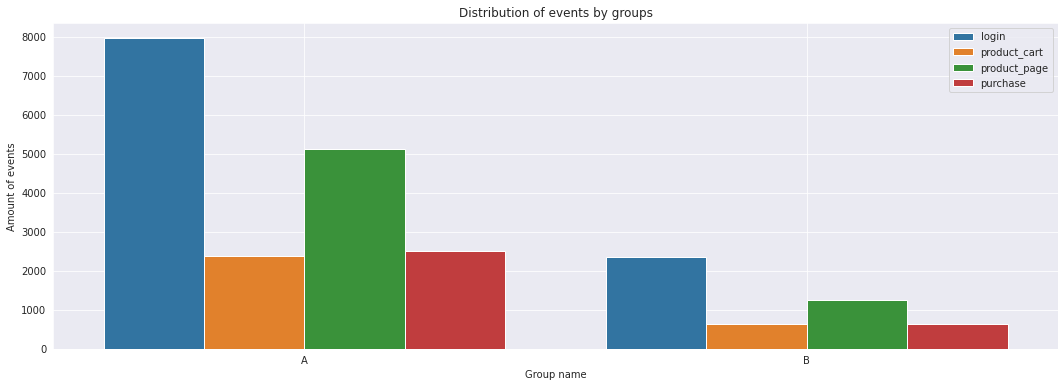

In [62]:
sns.set_style('dark')

plt.figure(figsize=(18, 6))

sns.barplot(x='group', y='event_dt_date', data=events_new.groupby(['group', 'event_name'])['event_dt_date'].count().reset_index(), hue='event_name')

plt.title('Distribution of events by groups')
plt.xlabel('Group name')
plt.ylabel('Amount of events')
plt.legend(loc='upper right', fontsize=10)
plt.grid()

plt.show()

The number of events in groups is distributed proportionally, although there are three times fewer events in group B.

Let's see if the filtered test participants made up 15% of all customers in Europe, as stated in the Technical task.

In [63]:
test_participants = events_new['user_id'].tolist()

In [64]:
print('Percentage of filtered test takers in total European customers -',\
      round(total_users.query('user_id in @test_participants')['region'].value_counts()[0] / total_users_by_regions[0] * 100, 2), '%')
print()
print('15% required, not enough',\
      round(15 - round(total_users.query('user_id in @test_participants')['region'].value_counts()[0] / total_users_by_regions[0] * 100, 2), 2), 'p.p.')


Percentage of filtered test takers in total European customers - 7.52 %

15% required, not enough 7.48 p.p.


So, the conclusions on compliance with the data of the Technical task:

YES:
- Test name: `recommender_system_test`;
- groups: A - control, B - new payment funnel;
- launch date: 2020-12-07;
- date of stopping the recruitment of new users: 2020-12-21;
- stop date: 2021-01-04;
- filtered out 14 days since registration.

NO:
- Data ends on 2020-12-30 instead of 2021-01-04;
- the audience of new users from the EU region is not equal to the declared 15%, in fact - half as much
- expected number of test participants: 6000.
- participants are much less than the declared 6000, but those who have events - 3481.

We have very few days of observation to collect cohorts of visitors and evaluate changes in events in these cohorts. From 7 to 24 December - 18 days. The Christmas Promo starts on the 25th. It formally intersects with the test for 11 days, but in fact, since the data of events only until December 30 - 6.

## Let's do an exploratory data analysis

### Are the number of events per user equally distributed across the samples?


In [65]:
events_new.groupby('user_id').agg({'event_name': 'count'}).describe()

,event_name
count,"3,481.00"
mean,6.56
std,3.77
min,1.00
25%,4.00
50%,6.00
75%,9.00
max,24.00


There are 7 events per user on average. The median is slightly lower - 6. This means that there should not be many outliers.

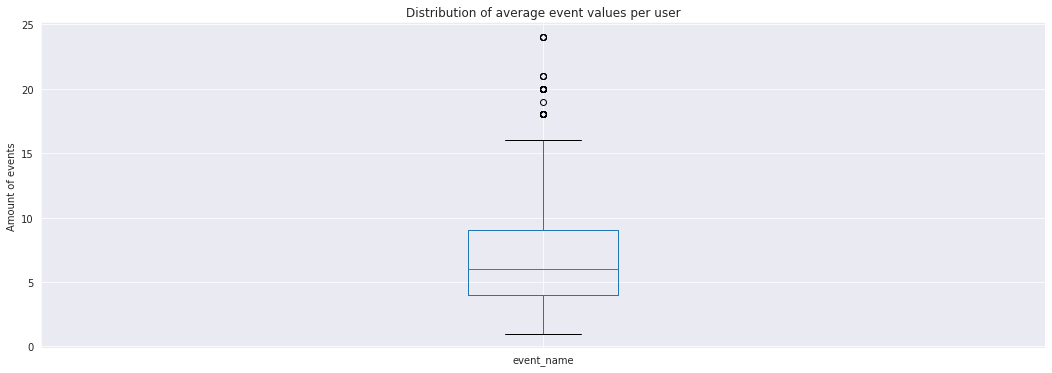

In [66]:
events_new.groupby('user_id').agg({'event_name': 'count'}).boxplot(figsize=(18, 6))

plt.title('Distribution of average event values per user')
plt.ylabel('Amount of events');

There are outliers, but they are not few. It is quite possible that some users zealously visit the site, study the content, but do not buy anything.

Let's look at the events in the samples by day.

In [67]:
distribution_by_days = events_new.groupby(['event_dt_date', 'group'])['event_name'].count().reset_index()
distribution_by_days['event_dt_date'] = distribution_by_days['event_dt_date'].dt.strftime('%Y-%m-%d')


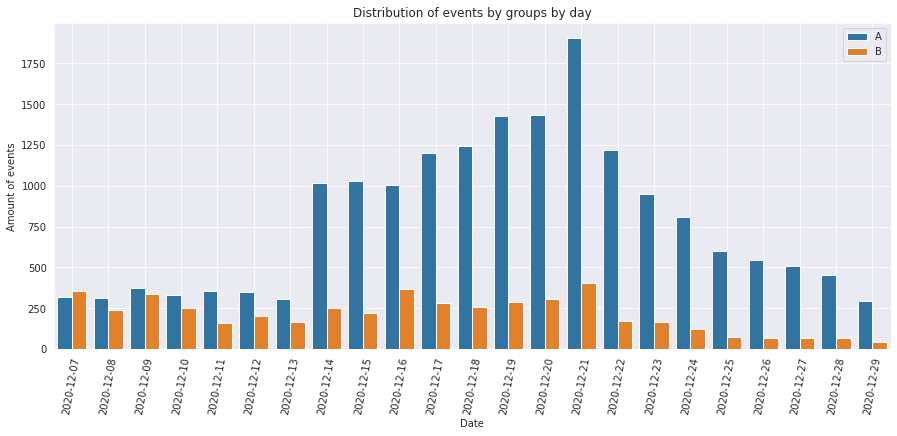

In [68]:
sns.set_style('dark')

plt.figure(figsize=(15, 6))

sns.barplot(x='event_dt_date', y='event_name', data=distribution_by_days, hue='group')

plt.title('Distribution of events by groups by day')
plt.xlabel('Date')
plt.ylabel('Amount of events')
plt.legend(loc='upper right', fontsize=10)
plt.grid()
plt.xticks(rotation=80)
plt.show()

On the first day, the sample of group B is even slightly higher. Starting from the second week (from December 7, on Monday), sample A has a fourfold quantitative lead in sample B. Group A indicators are growing throughout the second week. At the beginning of the third (December 21, again Monday) there is a peak of both samples. After December 21, group A has a clear decrease in the number of events, group B has a slight decrease. Note that the decrease occurs at the beginning of the advertising campaign and during the Christmas and New Year holidays.

### Event Funnels

Let's determine how many users made each of the events, as well as the proportion of users who made the event at least once. Let's not forget about the sequence of actions in the funnel that we set above.

In [69]:
events_new_A = events_new.query('group == "A"')
events_new_B = events_new.query('group == "B"')


In [70]:
parts_users_per_event_part_A= (events_new_A
                               .groupby('event_name').agg(number_of_users = ('user_id', 'nunique'))
                               .reset_index()
                               .sort_values('number_of_users', ascending=False)
                               .assign(user_share = lambda x: x['number_of_users'] * 100 / events_new_A['user_id']
                                       .nunique())
                                       )

parts_users_per_event_part_A.reindex([0,2,1,3])


,event_name,number_of_users,user_share
0,login,2604,100.00
2,product_page,1685,64.71
1,product_cart,782,30.03
3,purchase,833,31.99


In [71]:
parts_users_per_event_part_B= (events_new_B
                               .groupby('event_name').agg(number_of_users = ('user_id', 'nunique'))
                               .reset_index()
                               .sort_values('number_of_users', ascending=False)
                               .assign(user_share = lambda x: x['number_of_users'] * 100 / events_new_B['user_id']
                                       .nunique())
                                       )

parts_users_per_event_part_B.reindex([0,2,1,3])

,event_name,number_of_users,user_share
0,login,876,99.89
2,product_page,493,56.21
1,product_cart,244,27.82
3,purchase,249,28.39


According to the fact that not everyone is logged in, you can buy through third-party sites.

In [72]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Group А',
    y = ["login", "product_page",\
         "product_cart", "purchase	"],
    x = [2604, 1685, 782, 833],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Group B',
    orientation = "h",
    y = ["login", "product_page",\
         "product_cart", "purchase	"],
    x = [876, 493, 244, 249],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.update_layout(title="Event Funnel", width=1200, height=500)
fig.show()

Looking at the funnels, group A looks better. Less customers are lost in shares of the original number. 65% of the original quantity reaches the `product_page` stage, in group B only 56%.

So, strong disproportion in groups. The number of customers is half the expected number. Not all days of the test have information on user actions. Extremely bad time for test. The test may be influenced by external factors in the form of a Christmas and New Year advertising campaign, holiday sales.

## Examine the results of A/B testing

Determine how many users are in each group, add a column with the total number of users in each group.

In [73]:
users_by_events = events_new\
.pivot_table(index=['group'], columns = ['event_name'], values = 'user_id', aggfunc = 'nunique').reset_index()

users_by_events = users_by_events[['group',	'login',	'product_page', 'product_cart',	'purchase']]

users_total = events_new.groupby('group')['user_id'].nunique()

users_by_events['users_total'] = users_by_events['group'].apply(lambda x: users_total.loc[x])
users_by_events = users_by_events.set_index('group')

users_by_events

event_name,login,product_page,product_cart,purchase,users_total
group,,,,,
A,2604,1685,782,833,2604
B,876,493,244,249,877


We use the Z-test. We use it, since we compare the shares at each stage of the total number of unique users. It is important to check the number of unique users who visited a particular stage. This is necessary in order to understand that the user generally visited this or that page.

Recall the formula:

$$Z = \frac{(P_1-P_2)(π_1 - π_2)}{\sqrt{P(1-P)(1/n_1+1/n_2)}}\sim N(0, 1)$$

For convenience, let's write a function.

In [74]:
def st_test(part0, part1, total0, total1, alpha):  
    p1 = part0 / total0 
    p2 = part1 / total1 
    p_combined = (part0 + part1) / (total0 + total1) 
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total0 + 1/total1))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value
 

    H_0: Group A sample event share = Group B event share
    H_a: Group A sample event share ≠ Group B event share
   
    alpha = 0.05

In [75]:
pd.options.display.max_colwidth = 150
AB_pivot = pd.DataFrame(columns=['Group_1', 'Group_2', 'Event', 'p_alpha', 'p_value', 'Result'])
 
result_options = ["We reject the null hypothesis that there is a statistically significant difference between the shares",
                   "It was not possible to reject the null hypothesis, there is no reason to consider the shares different"]

group_1 = 'A'
current_row = users_by_events.loc[group_1]
group_2 = 'B'
for event_number in range(4):
    curr_event = users_by_events.columns[event_number]
    p_value_result = st_test(current_row[curr_event], 
                                   users_by_events[curr_event][group_2],
                                   current_row['users_total'],
                                   users_by_events['users_total'][group_2],
                                   alpha = 0.05)    
    new_row = {'Группа_1': group_1,
               'Группа_2': group_2,
               'Событие': users_by_events.columns[event_number],
               'p_alpha': 0.05,
               'p_value': p_value_result,
               'Результат': result_options[int(p_value_result >= 0.05)]}
    AB_pivot = AB_pivot.append([new_row])
 
AB_pivot.index = range(len(AB_pivot))
AB_pivot              

,Group_1,Group_2,Event,p_alpha,p_value,Result,Группа_1,Группа_2,Событие,Результат
0,NaN,NaN,NaN,0.05,0.08,NaN,A,B,login,"It was not possible to reject the null hypothesis, there is no reason to consider the shares different"
1,NaN,NaN,NaN,0.05,0.00,NaN,A,B,product_page,We reject the null hypothesis that there is a statistically significant difference between the shares
2,NaN,NaN,NaN,0.05,0.21,NaN,A,B,product_cart,"It was not possible to reject the null hypothesis, there is no reason to consider the shares different"
3,NaN,NaN,NaN,0.05,0.05,NaN,A,B,purchase,We reject the null hypothesis that there is a statistically significant difference between the shares


The test showed a difference in conversion between groups at the `product_page` and `purchase` stages. Let's adjust our final p_values using the Holm-Shydak correction. Correction is needed, since we have a multiple non-parametric test.

In [76]:
result_options = ["We reject the null hypothesis that there is a statistically significant difference between the shares",
                   "It was not possible to reject the null hypothesis, there is no sufficient reason to consider the shares to be different"]
 
pvalues_corr_list = []  
final_results = []  

for i in range(0, len(AB_pivot), 4):
    pvalues_list = AB_pivot.loc[i:i+3, 'p_value'].tolist()
    results, p_value_corr, _, _ = multi_correction.multipletests(pvalues_list, method='holm-sidak')
    pvalues_corr_list.extend([round(x, 5) for x in p_value_corr])
    final_results.extend([result_options[0] if x else result_options[1] for x in results])
 
AB_pivot = AB_pivot.drop('Result', axis=1)
AB_pivot['p_value_corr'] = pvalues_corr_list
AB_pivot['Final result'] = final_results
 
AB_pivot

,Group_1,Group_2,Event,p_alpha,p_value,Группа_1,Группа_2,Событие,Результат,p_value_corr,Final result
0,NaN,NaN,NaN,0.05,0.08,A,B,login,"It was not possible to reject the null hypothesis, there is no reason to consider the shares different",0.16,"It was not possible to reject the null hypothesis, there is no sufficient reason to consider the shares to be different"
1,NaN,NaN,NaN,0.05,0.00,A,B,product_page,We reject the null hypothesis that there is a statistically significant difference between the shares,0.00,We reject the null hypothesis that there is a statistically significant difference between the shares
2,NaN,NaN,NaN,0.05,0.21,A,B,product_cart,"It was not possible to reject the null hypothesis, there is no reason to consider the shares different",0.21,"It was not possible to reject the null hypothesis, there is no sufficient reason to consider the shares to be different"
3,NaN,NaN,NaN,0.05,0.05,A,B,purchase,We reject the null hypothesis that there is a statistically significant difference between the shares,0.13,"It was not possible to reject the null hypothesis, there is no sufficient reason to consider the shares to be different"


Only at the `product_page` stage, a statistically significant difference in conversions was found.

## Сonclusions

The timing of the test was extremely unfortunate. The most powerful external factors in the form of New Year and Christmas holidays, sales, promotional campaign, 11 days of which intersect with the dates of the test. Although in fact there is less data on events - they do not end on January 4, when the test stops, but on December 30. And then on this day the data is clearly incomplete.

The collected data correspond to the Technical task only partially. The number of test participants is less than the declared 6000, the audience is much less than the planned 15% of new users from Europe. There is a strong disproportion in the samples. Unique users in the test group - only 20% of the total.

An analysis of the event funnel showed that the conversion in the events of the control group A looks better. Less customers are lost in shares of the original number. 65% of the initial quantity reaches the product_page stage, in group B only 56%. 

The conversion of the `product_page` event in test group B is over 13% lower.

The conversion of the `product_cart` event in test group B is over 7% lower.

The `purchase` event conversion in test group B is over 12% lower.

Statistic test did not see a statistically significant difference in the conversions of three of the four events in the control and test groups. Only at the `product_page` stage, a statistically significant difference in conversions was found.

Thus, the study showed that the introduction of an improved recommender system did not achieve the stated goals. However, one should not forget about strong external factors, as well as data that only partially corresponded to the TOR, plus doubts about the adequacy of the data are caused by the fact that, starting from December 14, unique users without events no longer fall into the control group.

For a more correct study, we recommend repeating the test and riddance the shortcomings identified during this analysis.